<a href="https://colab.research.google.com/github/dlwjdals102/Big-Data-Project/blob/main/Steam_Game_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Steam 게임 분석

In [25]:
!pip install requests beautifulsoup4 pandas

!pip install numpy

1. 데이터 수집



In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import matplotlib.pyplot as plt

In [4]:
# 게임 순위 (플레이어 수 기준)

# SteamCharts의 단일 페이지를 스크랩하는 기능
def scrape_steamcharts(page=1):
    url = f"https://steamcharts.com/top/p.{page}"  # Page-specific URL
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # 게임 데이터가 포함된 테이블을 찾습니다.
    table = soup.find('table', {'class': 'common-table'})
    rows = table.find_all('tr')[1:]  # Skip the header row

    # 행별로 데이터 추출
    data = []
    for row in rows:
        cols = row.find_all('td')
        try:
            game_data = {
                'Rank': cols[0].text.strip(),
                'Name': cols[1].text.strip(),
                'Current Players': int(cols[2].text.replace(',', '').strip()),
                'Peak Players': int(cols[4].text.replace(',', '').strip()),
                'Hours Played': int(cols[5].text.replace(',', '').strip())
            }
            data.append(game_data)
        except (IndexError, ValueError) as e:
            print(f"Skipping row due to error: {e}")
            continue

    return data

# 여러 페이지에서 데이터 스크랩
all_data = []
num_pages = 8  # 더 많은 데이터를 스크랩하려면 페이지 수를 조정하세요.
for page in range(1, num_pages + 1):
    print(f"Scraping page {page}...")
    all_data.extend(scrape_steamcharts(page))
    time.sleep(2)  # 서버 과부하를 방지하려면 지연을 추가하세요.

# DataFrame으로 변환
df = pd.DataFrame(all_data)

# 데이터 세트 저장
df.to_csv('steamcharts_data.csv', index=False)

# 처음 몇 행 표시
print(df.head())

Scraping page 1...


NameError: name 'requests' is not defined

In [3]:
# 수집한 데이터의 필요한 속성 추가
# 장르

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

def get_genre(game_name):
    try:
        # Steam에서 게임을 검색.
        search_url = f"https://store.steampowered.com/search/?term={game_name.replace(' ', '+')}"
        response = requests.get(search_url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # 첫 번째 검색결과 찾기
        game_link_tag = soup.find('a', {'class': 'search_result_row'})
        if not game_link_tag:
            print(f"No game link found for {game_name}")
            return 'Game Not Found'

        game_link = game_link_tag['href']

        # 게임 페이지 가져오기
        game_page = requests.get(game_link)
        game_soup = BeautifulSoup(game_page.content, 'html.parser')

        # 장르 섹션 찾기
        genre_section = game_soup.find('div', {'class': 'details_block'})
        if genre_section:
            genre_text = genre_section.get_text(strip=True)
            if 'Genre:' in genre_text:
                genres = genre_text.split('Genre:')[-1].split(', ')
                return ', '.join(genres)

        return 'Unknown'
    except Exception as e:
        print(f"Error fetching genre for {game_name}: {e}")
        return 'Error'


# 데이터세트 로드
df = pd.read_csv('steamcharts_data.csv')

# 각 게임의 장르를 스크레이핑합니다(차단되지 않도록 지연 있음).
df['Genre'] = df['Name'].apply(lambda x: get_genre(x))
time.sleep(2)  # 속도 제한을 피하기 위해 요청 사이에 지연을 추가.

# 업데이트된 데이터 세트 저장
#df.to_csv('steam_data_with_genres.csv', index=False)

# 처음 몇 행 표시
print(df.head())

No game link found for 雀魂麻将(MahjongSoul)
   Rank                 Name  Current Players  Peak Players  Hours Played  \
0   1.0     Counter-Strike 2          1479726       1525073     616532103   
1   2.0  PUBG: BATTLEGROUNDS           681835        796001     229543331   
2   3.0               Dota 2           665984        797599     328672133   
3   4.0   NARAKA: BLADEPOINT           227427        330690      72684992   
4   5.0   Grand Theft Auto V           173567        186241      72254303   

                                               Genre  
0  Action,Free To PlayDeveloper:ValvePublisher:Va...  
1  Action,Adventure,Massively Multiplayer,Free To...  
2  Action,Strategy,Free To PlayDeveloper:ValvePub...  
3  Action,Adventure,Massively MultiplayerDevelope...  
4  Action,AdventureDeveloper:Rockstar NorthPublis...  


In [4]:
# 수집한 데이터의 속성 추가
# 가격

def get_price(game_name):
    try:
        # Steam에서 게임 검색
        search_url = f"https://store.steampowered.com/search/?term={game_name.replace(' ', '+')}"
        response = requests.get(search_url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # 첫 번째 검색결과 찾기
        game_link_tag = soup.find('a', {'class': 'search_result_row'})
        if not game_link_tag:
            print(f"No game link found for {game_name}")
            return 'Unknown', 'No Discount'

        game_link = game_link_tag['href']

        # 게임 페이지 가져오기
        game_page = requests.get(game_link)
        game_soup = BeautifulSoup(game_page.content, 'html.parser')

        # 가격 및 할인 추출
        price_section = game_soup.find('div', {'class': 'game_purchase_price'})
        discounted_price = game_soup.find('div', {'class': 'discount_final_price'})
        discount_pct = game_soup.find('div', {'class': 'discount_pct'})

        price = discounted_price.get_text(strip=True) if discounted_price else (price_section.get_text(strip=True) if price_section else 'Unknown')
        discount = discount_pct.get_text(strip=True) if discount_pct else 'No Discount'

        return price, discount
    except Exception as e:
        print(f"Error fetching price for {game_name}: {e}")
        return 'Error', 'Error'


# 가격 및 할인 추가
print("Fetching prices...")
prices = df['Name'].apply(lambda x: get_price(x))
df['Price'] = prices.apply(lambda x: x[0])  # Price
df['Discount'] = prices.apply(lambda x: x[1])  # Discount
time.sleep(2)

print(df.head())

Fetching prices...
No game link found for 雀魂麻将(MahjongSoul)
   Rank                 Name  Current Players  Peak Players  Hours Played  \
0   1.0     Counter-Strike 2          1479726       1525073     616532103   
1   2.0  PUBG: BATTLEGROUNDS           681835        796001     229543331   
2   3.0               Dota 2           665984        797599     328672133   
3   4.0   NARAKA: BLADEPOINT           227427        330690      72684992   
4   5.0   Grand Theft Auto V           173567        186241      72254303   

                                               Genre         Price  \
0  Action,Free To PlayDeveloper:ValvePublisher:Va...        $24.62   
1  Action,Adventure,Massively Multiplayer,Free To...  Free To Play   
2  Action,Strategy,Free To PlayDeveloper:ValvePub...        $24.62   
3  Action,Adventure,Massively MultiplayerDevelope...  Free To Play   
4  Action,AdventureDeveloper:Rockstar NorthPublis...        $14.98   

      Discount  
0         -81%  
1  No Discount  
2    

In [5]:
# 수집한 데이터의 속성 추가
# 리뷰

def get_review_sentiment(game_name):
    try:
        # Steam에서 게임 검색
        search_url = f"https://store.steampowered.com/search/?term={game_name.replace(' ', '+')}"
        response = requests.get(search_url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # 첫 번째 검색결과 찾기
        game_link_tag = soup.find('a', {'class': 'search_result_row'})
        if not game_link_tag:
            print(f"No game link found for {game_name}")
            return 'Unknown'

        game_link = game_link_tag['href']

        # 게임 페이지 가져오기
        game_page = requests.get(game_link)
        game_soup = BeautifulSoup(game_page.content, 'html.parser')

        # 리뷰 감정 추출
        reviews_section = game_soup.find('div', {'class': 'user_reviews_summary_row'})
        if reviews_section and 'data-tooltip-html' in reviews_section.attrs:
            tooltip = reviews_section['data-tooltip-html']
            if tooltip:
                return tooltip.split('<br>')[0].strip()

        return 'Unknown'
    except Exception as e:
        print(f"Error fetching review sentiment for {game_name}: {e}")
        return 'Error'


# 리뷰 감정 추가print("Fetching review sentiments...")
df['Review Sentiment'] = df['Name'].apply(lambda x: get_review_sentiment(x))
time.sleep(2)

# 업데이트된 데이터 세트 저장
df.to_csv('total_steam_data.csv', index=False)

print(df.head())

No game link found for 雀魂麻将(MahjongSoul)
   Rank                 Name  Current Players  Peak Players  Hours Played  \
0   1.0     Counter-Strike 2          1479726       1525073     616532103   
1   2.0  PUBG: BATTLEGROUNDS           681835        796001     229543331   
2   3.0               Dota 2           665984        797599     328672133   
3   4.0   NARAKA: BLADEPOINT           227427        330690      72684992   
4   5.0   Grand Theft Auto V           173567        186241      72254303   

                                               Genre         Price  \
0  Action,Free To PlayDeveloper:ValvePublisher:Va...        $24.62   
1  Action,Adventure,Massively Multiplayer,Free To...  Free To Play   
2  Action,Strategy,Free To PlayDeveloper:ValvePub...        $24.62   
3  Action,Adventure,Massively MultiplayerDevelope...  Free To Play   
4  Action,AdventureDeveloper:Rockstar NorthPublis...        $14.98   

      Discount                                   Review Sentiment  
0      

2. 데이터 정리 및 전처리

In [6]:
# 장르 데이터를 수집하면 장르, 개발자, 퍼블리셔, 출시일자가 묶여서 들어옴
# 분할 필요

# 세부정보를 별도의 열로 분할하는 기능
def split_game_details(details):
    # Default values
    genre = ''
    developer = ''
    publisher = ''
    release_date = ''

    # 문자열을 여러 부분으로 나누기
    parts = details.split(' ')

    # 장르 추출 (before "Developer:")
    if 'Developer:' in details:
        genre = details.split('Developer:')[0].strip()

    # 개발자 추출
    if 'Developer:' in details:
        developer_part = details.split('Developer:')[-1]
        if 'Publisher:' in developer_part:
            developer = developer_part.split('Publisher:')[0].strip()
        else:
            developer = developer_part.strip()

    # 퍼블리셔 추출
    if 'Publisher:' in details:
        publisher_part = details.split('Publisher:')[-1]
        if 'Release Date:' in publisher_part:
            publisher = publisher_part.split('Release Date:')[0].strip()
        else:
            publisher = publisher_part.strip()

    # 출시날짜 추출
    if 'Release Date:' in details:
        release_date = details.split('Release Date:')[-1].strip()

    return pd.Series([genre, developer, publisher, release_date])

# 데이터세트 로드
df = pd.read_csv('total_steam_data.csv')

# 데이터프레임에 함수 적용
df[['Genre', 'Developer', 'Publisher', 'Release Date']] = df['Genre'].apply(split_game_details)

df.to_csv('total_steam_data.csv', index=False)

# 처음 몇 행 표시
print(df.head())

   Rank                 Name  Current Players  Peak Players  Hours Played  \
0   1.0     Counter-Strike 2          1479726       1525073     616532103   
1   2.0  PUBG: BATTLEGROUNDS           681835        796001     229543331   
2   3.0               Dota 2           665984        797599     328672133   
3   4.0   NARAKA: BLADEPOINT           227427        330690      72684992   
4   5.0   Grand Theft Auto V           173567        186241      72254303   

                                               Genre         Price  \
0                                Action,Free To Play        $24.62   
1  Action,Adventure,Massively Multiplayer,Free To...  Free To Play   
2                       Action,Strategy,Free To Play        $24.62   
3             Action,Adventure,Massively Multiplayer  Free To Play   
4                                   Action,Adventure        $14.98   

      Discount                                   Review Sentiment  \
0         -81%  81% of the 55,109 user reviews 

In [7]:
# 리뷰 데이터 총 사용자의 몇퍼가 긍정적으로 표현에서
# 총 사용자를 Total Reviews열에 추가
# 데이터 수집이 안돼서 이렇게 추가함

def extract_review_details(tooltip_text):
    """
    Extracts Review Sentiment (e.g., 81%) and Total Reviews (e.g., 54057)
    from the tooltip text.
    """
    try:
        # 툴팁 텍스트를 분할하여 감정 및 리뷰 부분 추출
        sentiment_part = tooltip_text.split('of the')[0].strip()
        total_reviews_part = tooltip_text.split('user reviews')[0].split('of the')[1].strip()

        # 감정 비율 추출
        sentiment = sentiment_part.split('%')[0] + '%'

        # 총 리뷰 추출(정수로)
        total_reviews = int(''.join(filter(str.isdigit, total_reviews_part)))

        return sentiment, total_reviews
    except (IndexError, ValueError) as e:
        print(f"Error parsing tooltip text: {tooltip_text}. Error: {e}")
        return 'Unknown', 0

review_details = df['Review Sentiment'].apply(extract_review_details)

# 결과를 두 개의 새로운 열로 분할
#df['Review Sentiment'] = review_details.apply(lambda x: x[0])  # Sentiment (e.g., 81%)
df['Total Reviews'] = review_details.apply(lambda x: x[1])  # Total Reviews (e.g., 54057)

# 데이터 저장
df.to_csv('total_steam_data.csv', index=False)

# 업데이트된 DataFrame 표시
print(df.head())

Error parsing tooltip text: Unknown. Error: list index out of range
Error parsing tooltip text: Unknown. Error: list index out of range
Error parsing tooltip text: Unknown. Error: list index out of range
   Rank                 Name  Current Players  Peak Players  Hours Played  \
0   1.0     Counter-Strike 2          1479726       1525073     616532103   
1   2.0  PUBG: BATTLEGROUNDS           681835        796001     229543331   
2   3.0               Dota 2           665984        797599     328672133   
3   4.0   NARAKA: BLADEPOINT           227427        330690      72684992   
4   5.0   Grand Theft Auto V           173567        186241      72254303   

                                               Genre         Price  \
0                                Action,Free To Play        $24.62   
1  Action,Adventure,Massively Multiplayer,Free To...  Free To Play   
2                       Action,Strategy,Free To Play        $24.62   
3             Action,Adventure,Massively Multiplayer 

In [65]:
import pandas as pd

# 데이터세트 로드
file_path = 'total_steam_data.csv'
df = pd.read_csv(file_path)

# 데이터 세트 구조 확인
print(df.info())

# 처음 몇 행 표시
print("Dataset Loaded Successfully!")
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rank              200 non-null    float64
 1   Name              200 non-null    object 
 2   Current Players   200 non-null    int64  
 3   Peak Players      200 non-null    int64  
 4   Hours Played      200 non-null    int64  
 5   Genre             199 non-null    object 
 6   Price             200 non-null    object 
 7   Discount          200 non-null    object 
 8   Review Sentiment  200 non-null    object 
 9   Developer         199 non-null    object 
 10  Publisher         199 non-null    object 
 11  Release Date      197 non-null    object 
 12  Total Reviews     200 non-null    int64  
dtypes: float64(1), int64(4), object(8)
memory usage: 20.4+ KB
None
Dataset Loaded Successfully!
   Rank                 Name  Current Players  Peak Players  Hours Played  \
0   1.0     Coun

In [66]:
# Step 2: "가격" 열 정리
df['Price'] = df['Price'].replace({'Free To Play': 0}, regex=True)  # Replace "Free To Play" with 0
df['Price'] = df['Price'].str.replace('[$,]', '', regex=True)  # Remove $ and commas
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')  # Convert to numeric, invalid entries become NaN

# Step 3: "할인" 열 정리
df['Discount'] = df['Discount'].str.replace('%', '', regex=True)  # Remove %
df['Discount'] = df['Discount'].replace({'No Discount': 0}, regex=True)  # Replace "No Discount" with 0
df['Discount'] = pd.to_numeric(df['Discount'], errors='coerce')  # Convert to numeric

# Step 4: 리뷰 감정 비율 추출
df['Review Sentiment (%)'] = df['Review Sentiment'].str.extract(r'(\d+)%').astype(float)

# Step 5: "출시일" 열 형식 지정
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')

# Step 6: 큰 값을 정규화
df['Hours Played (millions)'] = df['Hours Played'] / 1e6
df['Current Players (thousands)'] = df['Current Players'] / 1e3

# Step 7: 누락된 값 확인
missing_values_summary = df.isnull().sum()

# 정리된 데이터 세트 및 누락된 값 표시
print("Cleaned Dataset Preview:")
print(df.head())
print("\nSummary of Missing Values:")
print(missing_values_summary)

Cleaned Dataset Preview:
   Rank                 Name  Current Players  Peak Players  Hours Played  \
0   1.0     Counter-Strike 2          1479726       1525073     616532103   
1   2.0  PUBG: BATTLEGROUNDS           681835        796001     229543331   
2   3.0               Dota 2           665984        797599     328672133   
3   4.0   NARAKA: BLADEPOINT           227427        330690      72684992   
4   5.0   Grand Theft Auto V           173567        186241      72254303   

                                               Genre  Price  Discount  \
0                                Action,Free To Play  24.62       -81   
1  Action,Adventure,Massively Multiplayer,Free To...    NaN         0   
2                       Action,Strategy,Free To Play  24.62       -81   
3             Action,Adventure,Massively Multiplayer    NaN         0   
4                                   Action,Adventure  14.98       -63   

                                    Review Sentiment         Developer  \

In [67]:
# 누락된 범주형 값을 '알 수 없음'으로 채웁니다.
df['Genre'] = df['Genre'].fillna('Unknown')
df['Developer'] = df['Developer'].fillna('Unknown')
df['Publisher'] = df['Publisher'].fillna('Unknown')

# 누락된 숫자 값 처리
df['Price'] = df['Price'].fillna(0)  # 누락된 가격을 0으로 채우기

# "출시 날짜", "검토 감정(%)"과 같은 중요한 값이 누락된 행을 삭제하세요.
df = df.dropna(subset=['Release Date'])
df = df.dropna(subset=['Review Sentiment (%)'])

# 아직 누락된 값이 있는지 확인하세요.
missing_values_summary_after = df.isnull().sum()
print("\nMissing Values After Handling:")
print(missing_values_summary_after)


Missing Values After Handling:
Rank                           0
Name                           0
Current Players                0
Peak Players                   0
Hours Played                   0
Genre                          0
Price                          0
Discount                       0
Review Sentiment               0
Developer                      0
Publisher                      0
Release Date                   0
Total Reviews                  0
Review Sentiment (%)           0
Hours Played (millions)        0
Current Players (thousands)    0
dtype: int64


In [68]:
# Step: "장르" 열을 개별 카테고리로 분할
# First, 분할 중 오류를 방지하려면 "장르"에 누락된 값을 입력하세요.
df['Genre'] = df['Genre'].fillna('Unknown')

# 장르를 개별 이진 열로 분할
genre_dummies = df['Genre'].str.get_dummies(sep=',')

# 이러한 이진 열을 원래 데이터세트에 다시 병합합니다.
df = pd.concat([df, genre_dummies], axis=1)

# 필요한 경우 원래 "장르" 열을 삭제하세요.
#df.drop(columns=['Genre'], inplace=True)

# 업데이트된 데이터 세트 표시
print("Updated Dataset with One-Hot Encoded Genres:")
print(df.head())

# 새로 생성된 장르 컬럼 목록을 확인하세요
print("\nNew Genre Columns:")
print(genre_dummies.columns.tolist())

Updated Dataset with One-Hot Encoded Genres:
   Rank                 Name  Current Players  Peak Players  Hours Played  \
0   1.0     Counter-Strike 2          1479726       1525073     616532103   
1   2.0  PUBG: BATTLEGROUNDS           681835        796001     229543331   
2   3.0               Dota 2           665984        797599     328672133   
3   4.0   NARAKA: BLADEPOINT           227427        330690      72684992   
4   5.0   Grand Theft Auto V           173567        186241      72254303   

                                               Genre  Price  Discount  \
0                                Action,Free To Play  24.62       -81   
1  Action,Adventure,Massively Multiplayer,Free To...   0.00         0   
2                       Action,Strategy,Free To Play  24.62       -81   
3             Action,Adventure,Massively Multiplayer   0.00         0   
4                                   Action,Adventure  14.98       -63   

                                    Review Sentiment 

In [69]:
# 전처리된 데이터 저장
df.to_csv('clean_total_steam_data.csv', index=False)

3. 분석 및 시각화

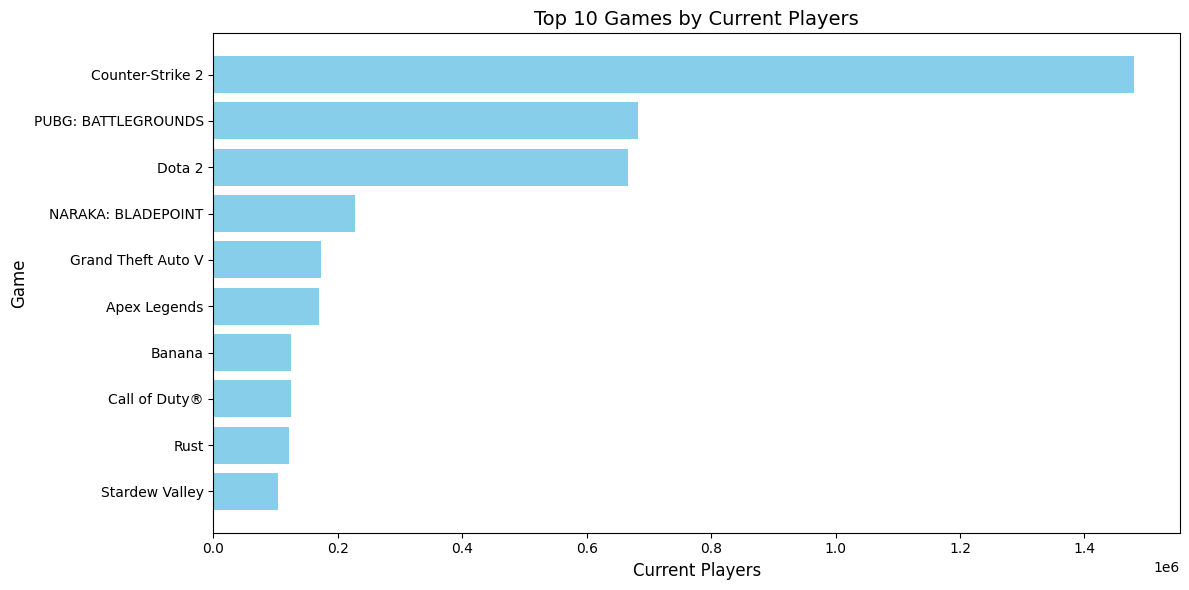

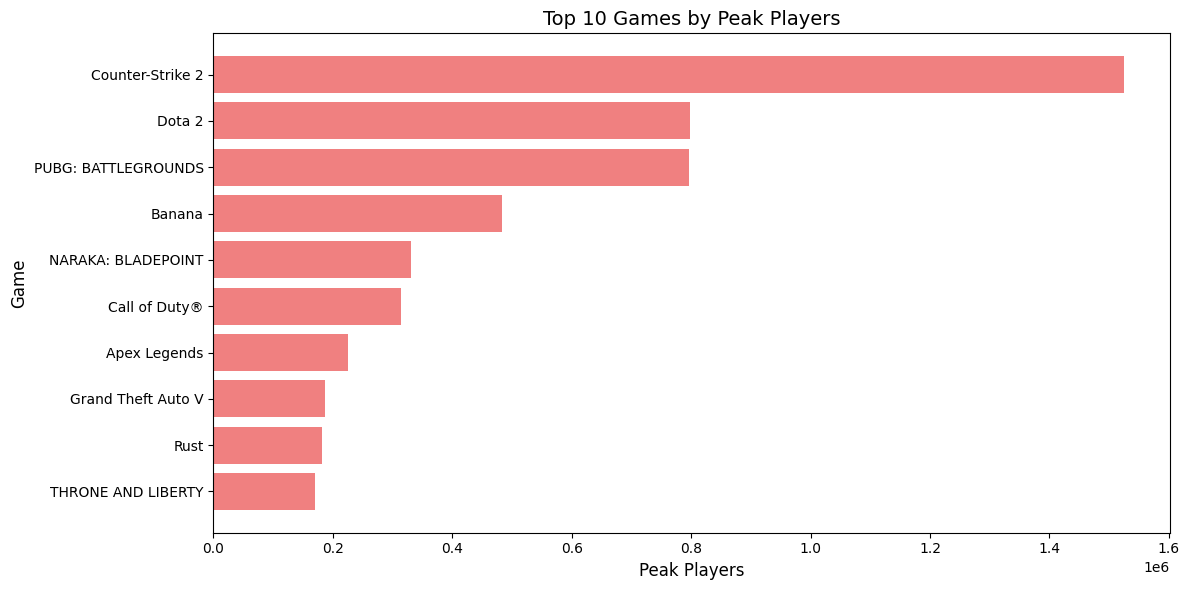

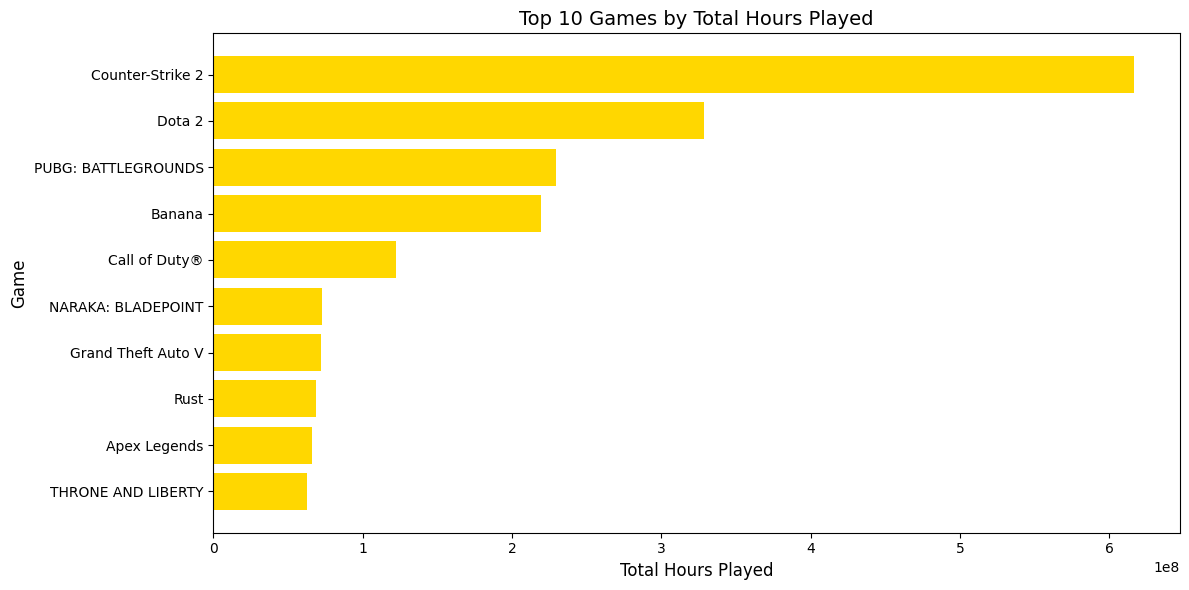

<Figure size 1400x800 with 0 Axes>

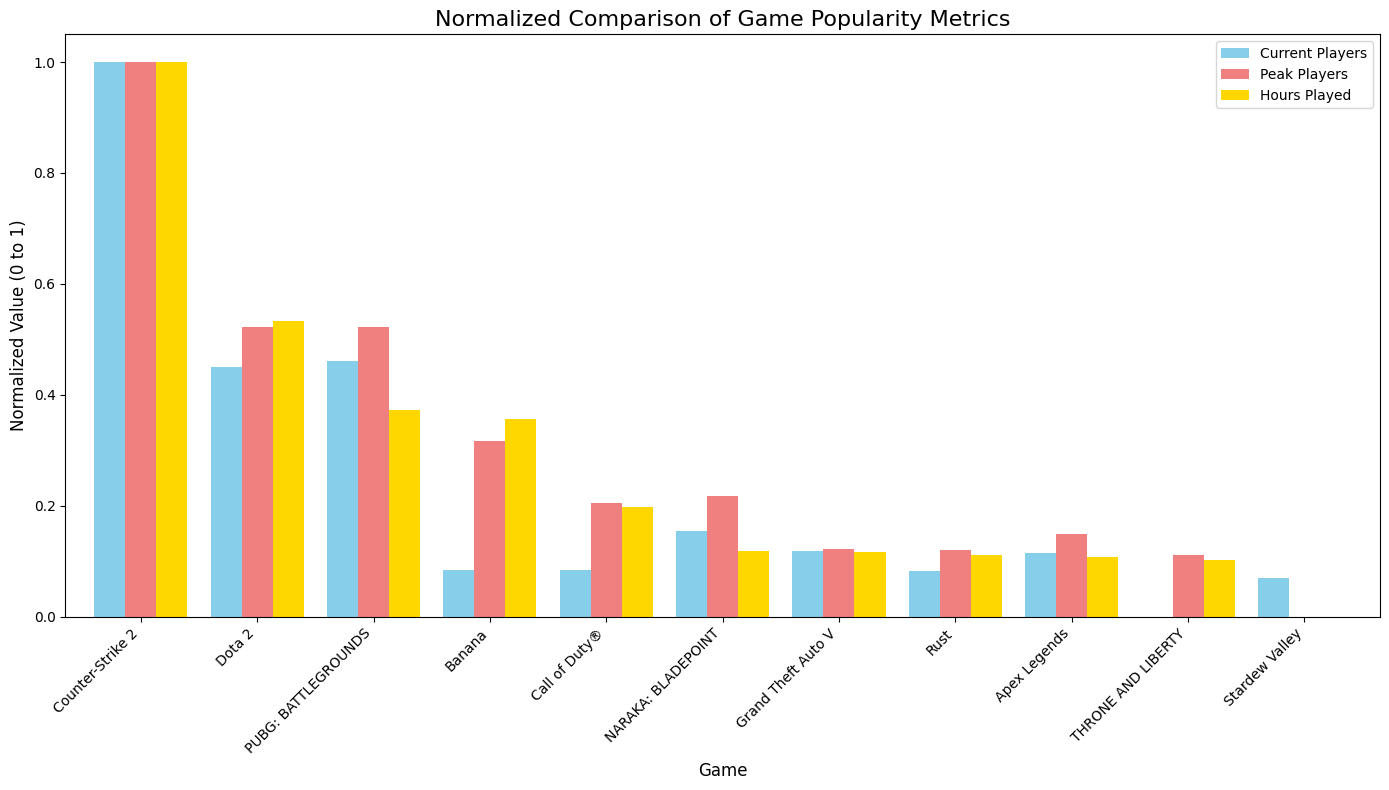

In [71]:
# 1. 게임 인기도
#현재 플레이어 또는 최고 플레이어를 기준으로 가장 인기 있는 게임을 식별
#상위 10개 게임의 총 플레이 시간("플레이 시간")을 비교

# 데이터세트 로드
file_path = 'clean_total_steam_data.csv'
data = pd.read_csv(file_path)

# 현재 플레이어의 상위 10개 게임
top_current_players = data.nlargest(10, 'Current Players')

# 현재 플레이어별 상위 10개 게임에 대한 막대 차트
plt.figure(figsize=(12, 6))
plt.barh(top_current_players['Name'], top_current_players['Current Players'], color='skyblue')
plt.xlabel('Current Players', fontsize=12)
plt.ylabel('Game', fontsize=12)
plt.title('Top 10 Games by Current Players', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()

# 최고 플레이어별 상위 10개 게임
top_peak_players = data.nlargest(10, 'Peak Players')

# 최고 플레이어별 상위 10개 게임에 대한 막대 차트
plt.figure(figsize=(12, 6))
plt.barh(top_peak_players['Name'], top_peak_players['Peak Players'], color='lightcoral')
plt.xlabel('Peak Players', fontsize=12)
plt.ylabel('Game', fontsize=12)
plt.title('Top 10 Games by Peak Players', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()

# 총 플레이 시간 기준 상위 10개 게임
top_hours_played = data.nlargest(10, 'Hours Played')

# 총 플레이 시간 기준 상위 10개 게임에 대한 막대 차트
plt.figure(figsize=(12, 6))
plt.barh(top_hours_played['Name'], top_hours_played['Hours Played'], color='gold')
plt.xlabel('Total Hours Played', fontsize=12)
plt.ylabel('Game', fontsize=12)
plt.title('Top 10 Games by Total Hours Played', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()

# 지표별 상위 게임 데이터를 하나의 DataFrame으로 병합
combined_top_games = pd.concat([
    top_current_players.set_index('Name')['Current Players'],
    top_peak_players.set_index('Name')['Peak Players'],
    top_hours_played.set_index('Name')['Hours Played']
], axis=1, join='outer').fillna(0)

# 더 나은 시각화를 위해 모든 지표에서 결합된 가장 높은 값을 기준으로 정렬
combined_top_games['Total Combined'] = combined_top_games.sum(axis=1)
combined_top_games = combined_top_games.sort_values('Total Combined', ascending=False).drop(columns='Total Combined')

# 측정항목을 정규화하여 비슷한 규모로 가져옵니다.
normalized_top_games = combined_top_games.div(combined_top_games.max())

# 정규화된 측정항목에 대해 그룹화된 막대 차트 만들기
plt.figure(figsize=(14, 8))
normalized_top_games.plot(kind='bar', figsize=(14, 8), width=0.8, color=['skyblue', 'lightcoral', 'gold'])
plt.title('Normalized Comparison of Game Popularity Metrics', fontsize=16)
plt.xlabel('Game', fontsize=12)
plt.ylabel('Normalized Value (0 to 1)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(['Current Players', 'Peak Players', 'Hours Played'], fontsize=10)
plt.tight_layout()
plt.show()

#일부 게임은 모든 지표(예: 세 가지 범주 모두에서 높은 정규화 값)에서 일관되게 성능을 발휘합니다.
#어떤 게임은 한 카테고리에서는 뛰어나지만 다른 카테고리에서는 뒤처질 수도 있습니다(예: 총 플레이 시간은 높지만 현재 플레이어 수가 적은 게임).

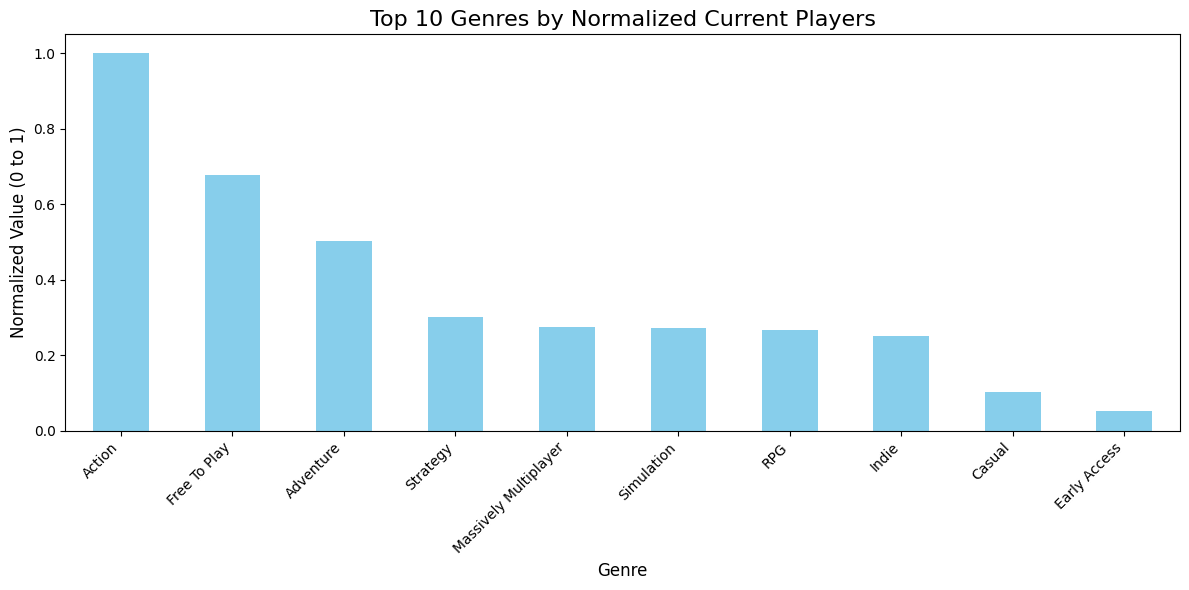

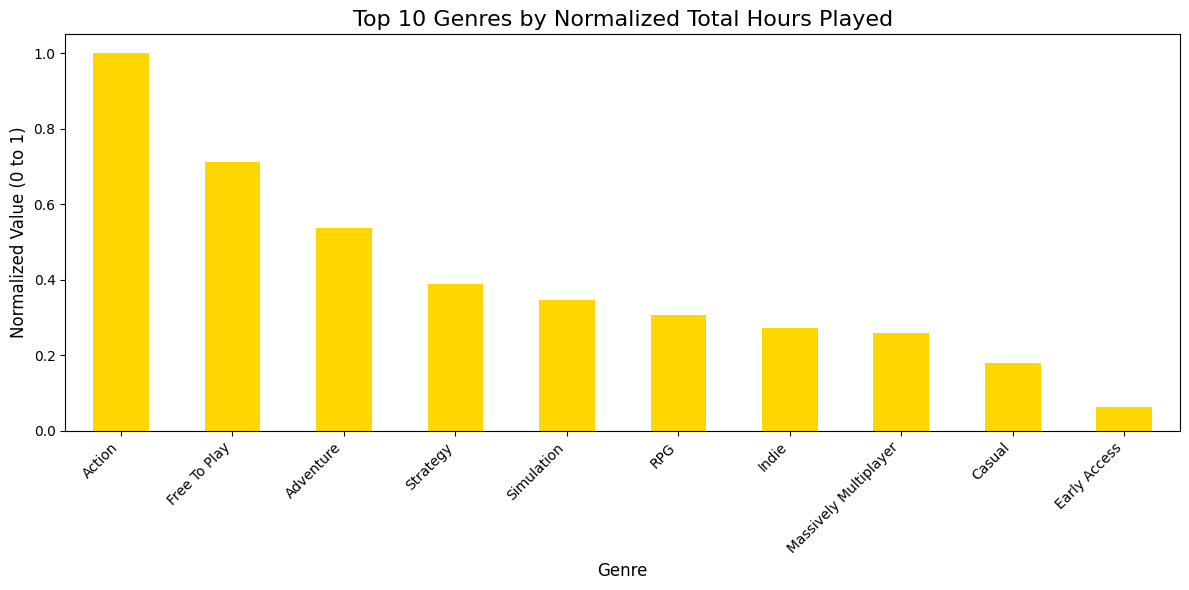

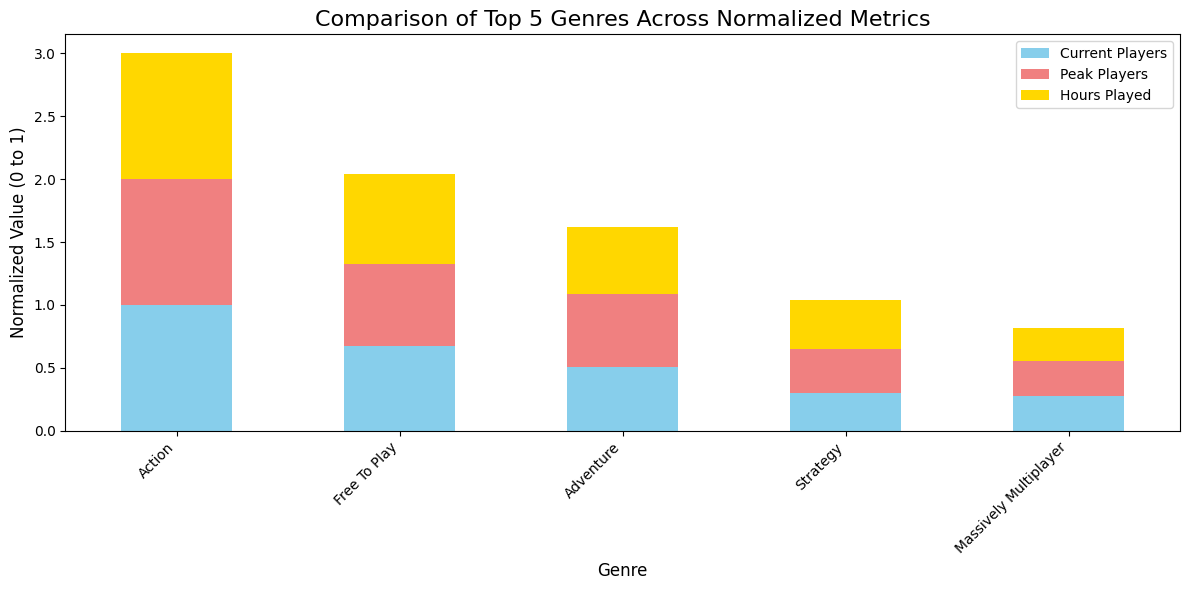

In [73]:
#2. 장르 분석

# 데이터세트 로드
file_path = 'clean_total_steam_data.csv'
data = pd.read_csv(file_path)

# 장르별 측정항목 요약
genre_columns = data.columns[16:]  # Adjust to match the genre one-hot encoded column range
genre_popularity = pd.DataFrame()

# 각 장르의 총 현재 플레이어, 최고 플레이어 및 플레이 시간을 계산합니다.
genre_popularity['Total Current Players'] = data[genre_columns].multiply(data['Current Players'], axis=0).sum()
genre_popularity['Total Peak Players'] = data[genre_columns].multiply(data['Peak Players'], axis=0).sum()
genre_popularity['Total Hours Played'] = data[genre_columns].multiply(data['Hours Played'], axis=0).sum()

# 총 현재 플레이어를 기준으로 정렬
genre_popularity_sorted = genre_popularity.sort_values(by='Total Current Players', ascending=False)

# 장르 인기도 표시
genre_popularity_sorted.head()

# 장르별 지표를 정규화
normalized_genre_popularity = genre_popularity_sorted.div(genre_popularity_sorted.max())

# 정규화된 현재 플레이어를 기준으로 상위 10개 장르 시각화
top_genres_normalized_current_players = normalized_genre_popularity['Total Current Players'].nlargest(10)

plt.figure(figsize=(12, 6))
top_genres_normalized_current_players.plot(kind='bar', color='skyblue')
plt.title('Top 10 Genres by Normalized Current Players', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Normalized Value (0 to 1)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

# 정규화된 총 재생 시간을 기준으로 상위 10개 장르를 시각화합니다.
top_genres_normalized_hours_played = normalized_genre_popularity['Total Hours Played'].nlargest(10)

plt.figure(figsize=(12, 6))
top_genres_normalized_hours_played.plot(kind='bar', color='gold')
plt.title('Top 10 Genres by Normalized Total Hours Played', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Normalized Value (0 to 1)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

# 모든 정규화된 측정항목에 걸쳐 상위 5개 장르에 대한 누적 막대 차트
top_5_genres_normalized = normalized_genre_popularity.nlargest(5, 'Total Current Players')
top_5_genres_normalized[['Total Current Players', 'Total Peak Players', 'Total Hours Played']].plot(
    kind='bar', figsize=(12, 6), stacked=True, color=['skyblue', 'lightcoral', 'gold']
)
plt.title('Comparison of Top 5 Genres Across Normalized Metrics', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Normalized Value (0 to 1)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(['Current Players', 'Peak Players', 'Hours Played'], fontsize=10)
plt.tight_layout()
plt.show()

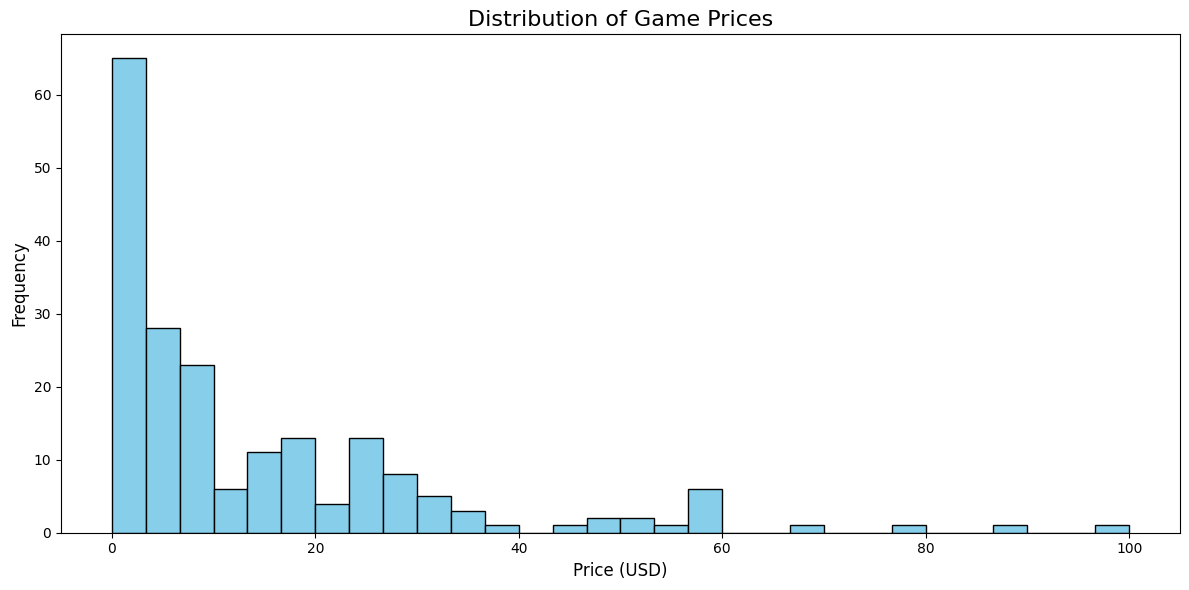

<ipython-input-77-13032c40ab9f>:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_category_analysis = data.groupby(price_categories)['Current Players'].mean()


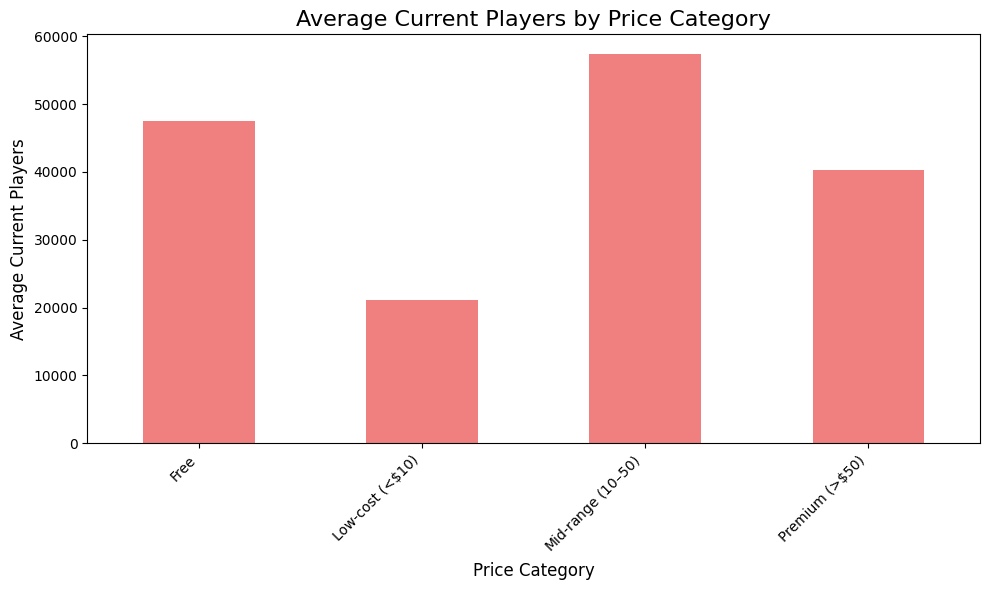

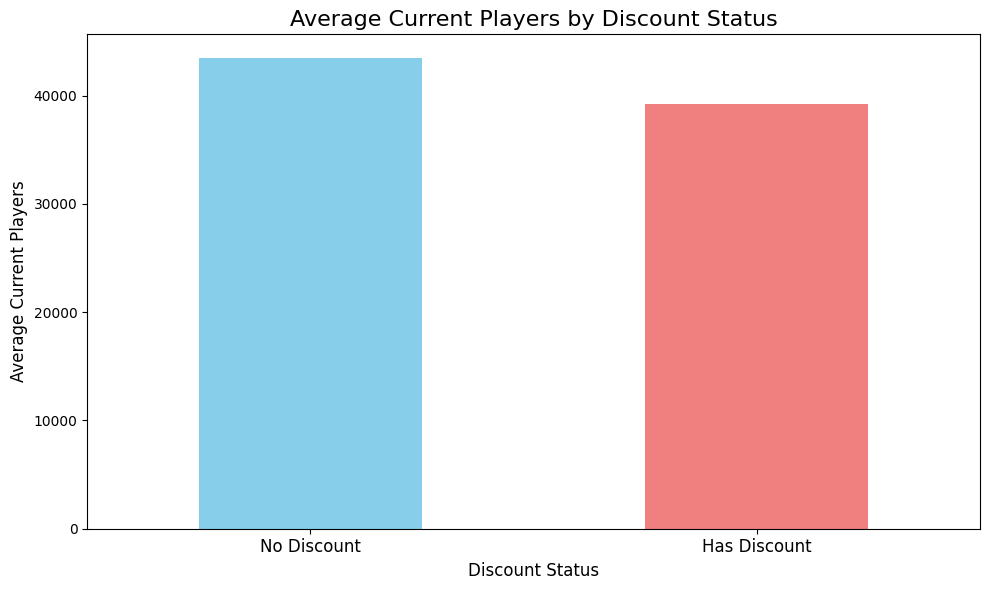

In [77]:
# 3. 가격 및 할인

# 데이터세트 로드
file_path = 'clean_total_steam_data.csv'
data = pd.read_csv(file_path)

# 게임 가격 히스토그램
plt.figure(figsize=(12, 6))
data['Price'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Game Prices', fontsize=16)
plt.xlabel('Price (USD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

# 가격대별로 게임을 분류
price_categories = pd.cut(
    data['Price'],
    bins=[-0.01, 0, 10, 50, data['Price'].max()],
    labels=['Free', 'Low-cost (<$10)', 'Mid-range ($10–$50)', 'Premium (>$50)']
)

# 각 가격 카테고리에 대한 평균 현재 플레이어를 계산합니다.
price_category_analysis = data.groupby(price_categories)['Current Players'].mean()

# 가격 카테고리별 평균 현재 플레이어에 대한 막대 차트
plt.figure(figsize=(10, 6))
price_category_analysis.plot(kind='bar', color='lightcoral')
plt.title('Average Current Players by Price Category', fontsize=16)
plt.xlabel('Price Category', fontsize=12)
plt.ylabel('Average Current Players', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

# 할인 상태에 따라 게임 분류
data['Has Discount'] = data['Discount'] < 0

# 할인이 있거나 없는 게임의 평균 현재 플레이어를 계산합니다.
discount_analysis = data.groupby('Has Discount')['Current Players'].mean()

# 할인 상태별 평균 현재 플레이어에 대한 막대 차트
plt.figure(figsize=(10, 6))
discount_analysis.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Average Current Players by Discount Status', fontsize=16)
plt.xlabel('Discount Status', fontsize=12)
plt.ylabel('Average Current Players', fontsize=12)
plt.xticks([0, 1], ['No Discount', 'Has Discount'], rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

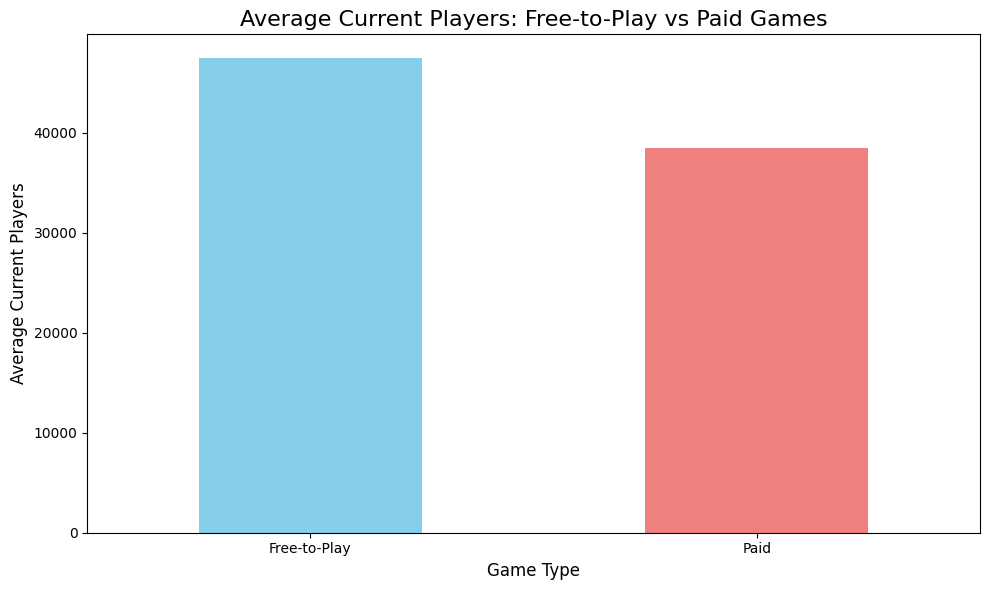

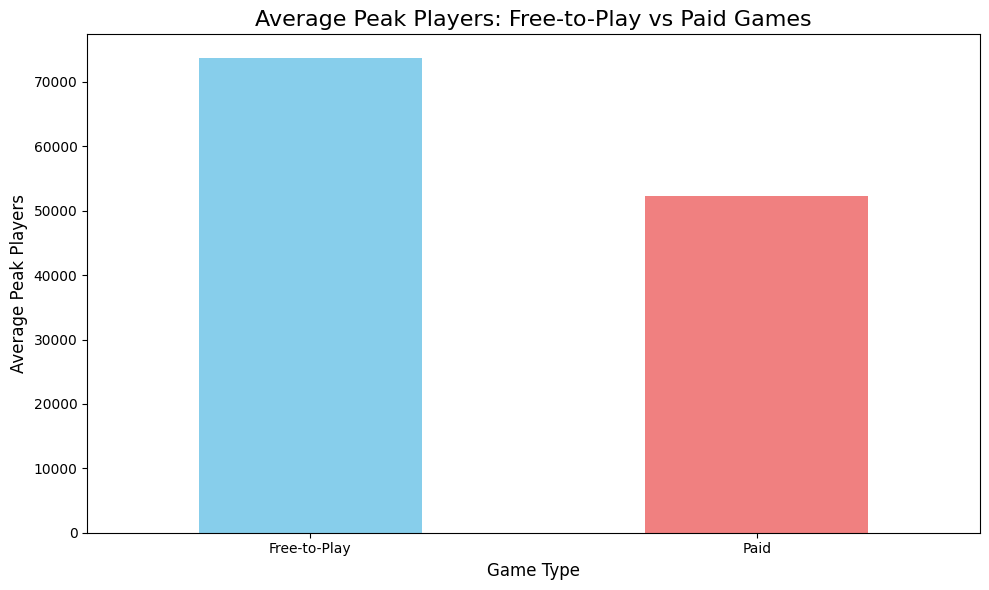

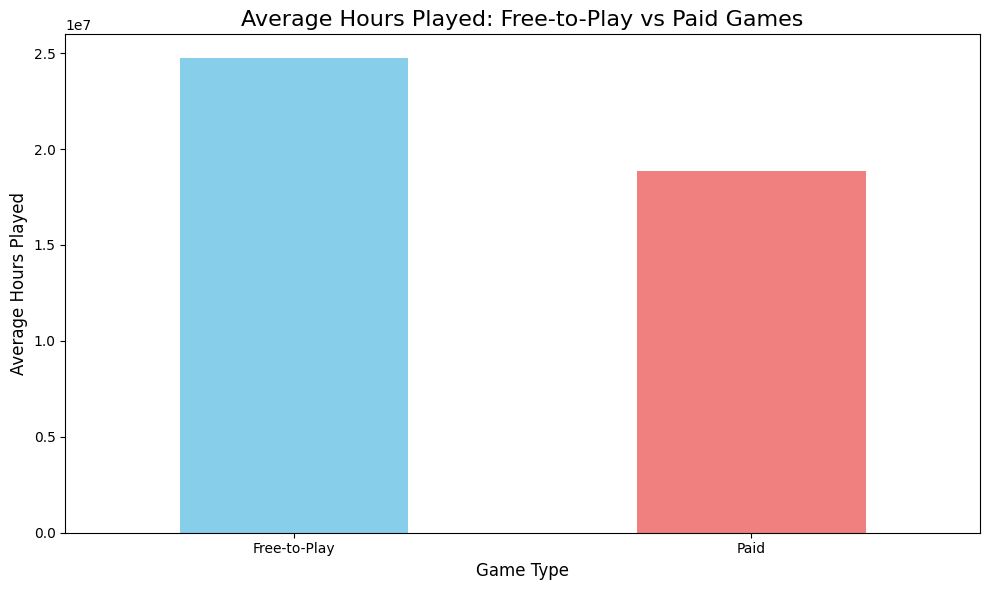

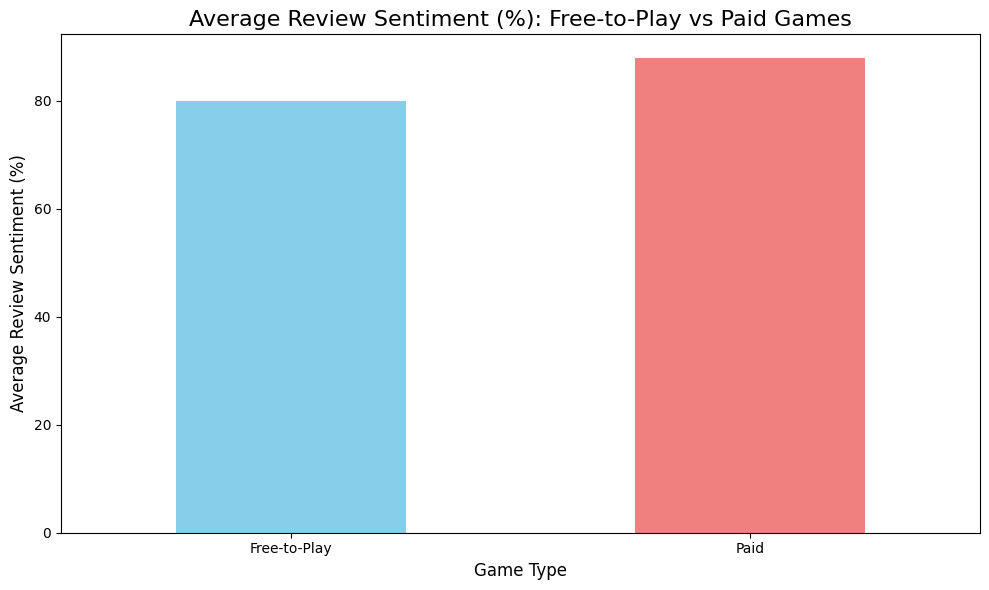

In [94]:
#4. 무료 플레이 게임의 영향

# 데이터세트 로드
file_path = 'clean_total_steam_data.csv'
data = pd.read_csv(file_path)

# Step 1: 게임을 무료 플레이 또는 유료로 분류
data['Game Type'] = data['Price'].apply(lambda x: 'Free-to-Play' if x == 0 else 'Paid')

# Step 2: 게임 유형별로 그룹화하고 참여 지표를 계산합니다.
game_type_analysis = data.groupby('Game Type')[['Current Players', 'Peak Players', 'Hours Played', 'Review Sentiment (%)']].mean()

# Step 3: 평균 현재 플레이어 시각화
plt.figure(figsize=(10, 6))
game_type_analysis['Current Players'].plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Average Current Players: Free-to-Play vs Paid Games', fontsize=16)
plt.xlabel('Game Type', fontsize=12)
plt.ylabel('Average Current Players', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Step 4: 추가 측정항목 시각화
metrics_to_plot = ['Peak Players', 'Hours Played', 'Review Sentiment (%)']
for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    game_type_analysis[metric].plot(kind='bar', color=['skyblue', 'lightcoral'])
    plt.title(f'Average {metric}: Free-to-Play vs Paid Games', fontsize=16)
    plt.xlabel('Game Type', fontsize=12)
    plt.ylabel(f'Average {metric}', fontsize=12)
    plt.xticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

#최고 플레이어:
#무료 플레이 게임은 최대 플레이어 참여도 측면에서 압도적이며, 주요 이벤트나 업데이트 중에 폭넓은 매력을 더욱 강화합니다.

#플레이 시간:
#평균 플레이 시간도 무료 플레이 게임의 경우 상당히 높으며, 이는 무료임에도 불구하고 장기적인 참여도가 높다는 것을 나타냅니다.

#감정 검토:
#흥미롭게도 유료 게임은 무료 게임에 비해 평균 리뷰 감정이 약간 더 높습니다.
#이는 유료 게임이 더욱 세련되고 만족스러운 경험을 제공할 수 있는 반면, 무료 게임은 플레이어 만족도의 변동성이 더 높다는 것을 의미합니다.

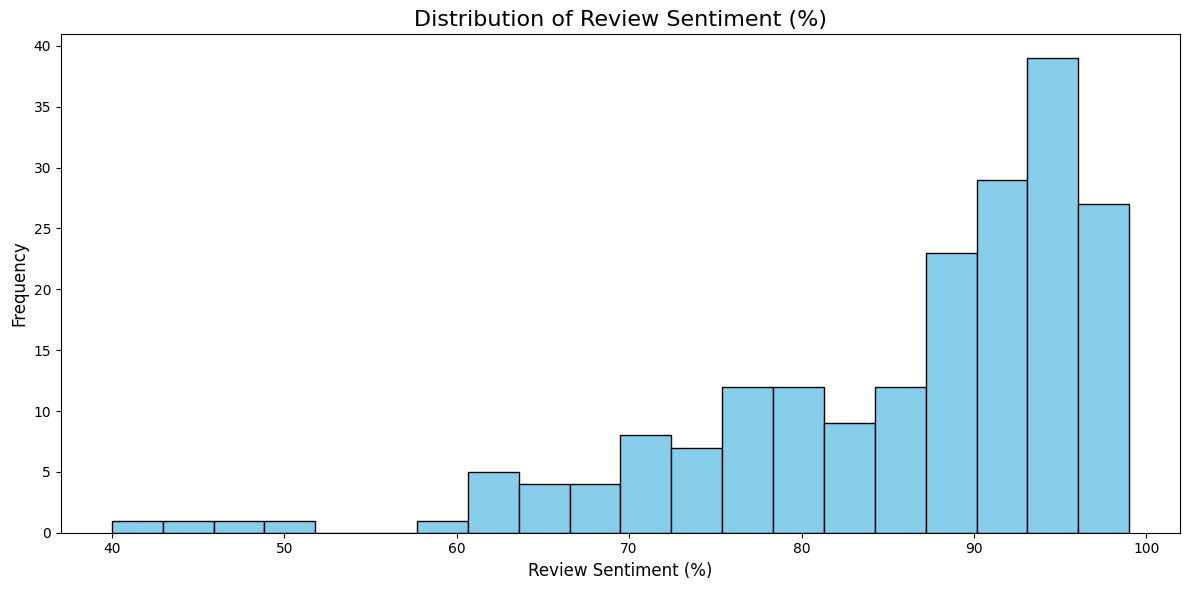

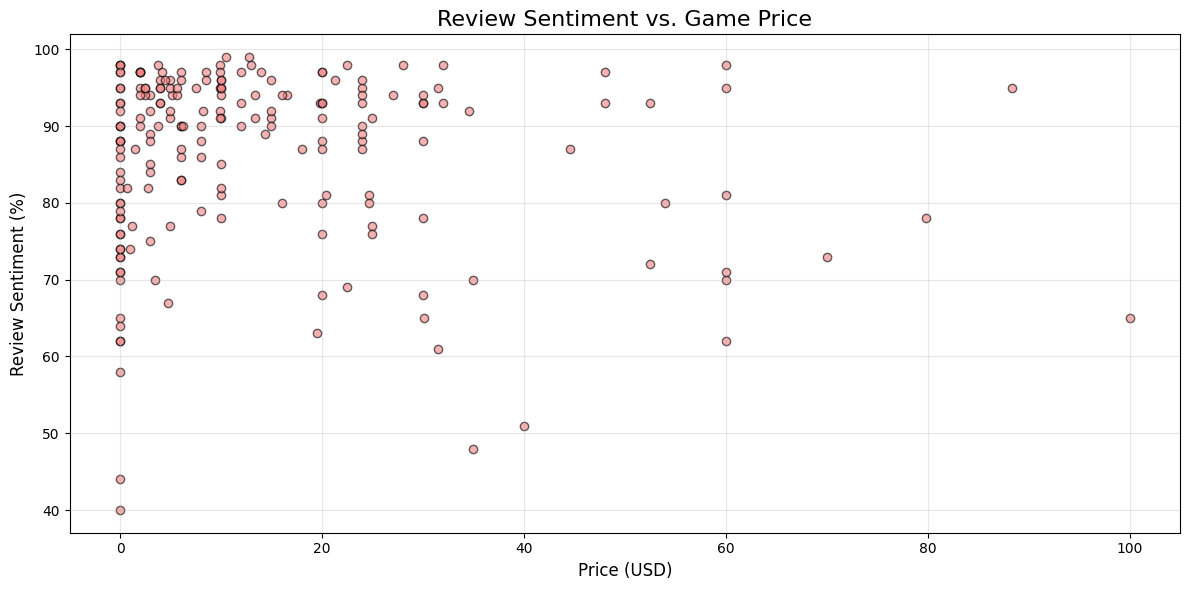

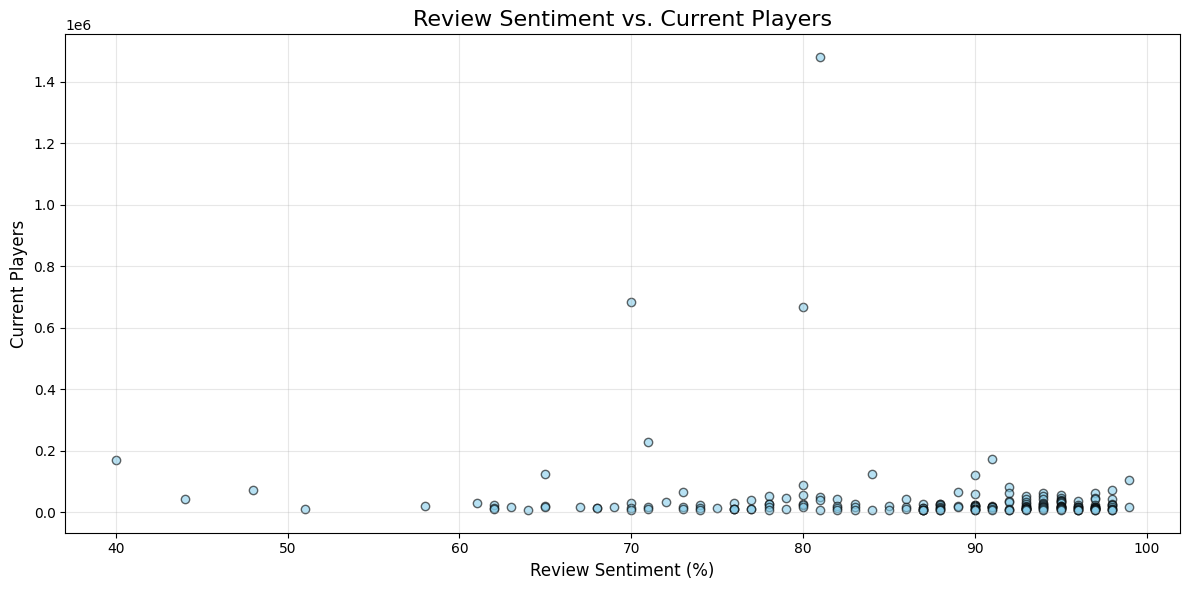

In [81]:
#5. 리뷰

# 데이터세트 로드
file_path = 'clean_total_steam_data.csv'
data = pd.read_csv(file_path)

# 리뷰 감정 히스토그램
plt.figure(figsize=(12, 6))
data['Review Sentiment (%)'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Sentiment (%)', fontsize=16)
plt.xlabel('Review Sentiment (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

#리뷰 감정 분포 결과:
#대부분의 게임은 60%~90% 사이의 리뷰 감정을 갖고 있으며 이는 일반적으로 긍정적인 플레이어 경험을 나타냅니다.
#리뷰 감정이 매우 높거나(90% 이상) 낮은(50% 미만) 게임의 비율이 더 낮습니다.

# 리뷰 감정 대 가격에 대한 산점도
plt.figure(figsize=(12, 6))
plt.scatter(data['Price'], data['Review Sentiment (%)'], alpha=0.6, color='lightcoral', edgecolor='black')
plt.title('Review Sentiment vs. Game Price', fontsize=16)
plt.xlabel('Price (USD)', fontsize=12)
plt.ylabel('Review Sentiment (%)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#무료 게임:
#매우 낮은 수준부터 매우 높은 수준까지 다양한 리뷰 감정을 포괄합니다.
#이는 가격이 무료 게임 리뷰에 영향을 미치는 유일한 요소가 아니라는 것을 의미합니다.

#유료 게임:
#가격이 더 높은(50달러 이상) 게임은 중간에서 높은 리뷰 감정을 중심으로 집중되는 경향이 있습니다.
#매우 고가의 게임은 일반적으로 낮은 리뷰 감정을 피하며 이는 특정 품질 기준을 유지할 수 있음을 나타냅니다.

# 리뷰 감정과 현재 플레이어의 산점도
plt.figure(figsize=(12, 6))
plt.scatter(data['Review Sentiment (%)'], data['Current Players'], alpha=0.6, color='skyblue', edgecolor='black')
plt.title('Review Sentiment vs. Current Players', fontsize=16)
plt.xlabel('Review Sentiment (%)', fontsize=12)
plt.ylabel('Current Players', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#보통 감정(60-80%):
#리뷰 감정이 이 범위에 있는 게임은 가장 인기 있는 일부 게임을 포함하여 다양한 플레이어 수를 유치합니다.
#높은 플레이어 참여를 유지하기 위해 게임에 완벽한 리뷰가 필요하지 않음을 나타냅니다.

#높은 감정(90%+):
#리뷰 감정이 유난히 높은 게임은 전용 플레이어 기반이 더 작은 경우가 많습니다.
#이러한 게임이 틈새 시장에 더 많은 관심을 끌 수 있다고 제안합니다.

#낮은 감정(<50%):
#리뷰 감정이 좋지 않은 게임에는 일반적으로 현재 플레이어 수가 적습니다. 이는 플레이어 감정이 플레이어 참여와 상관관계가 있음을 나타냅니다.


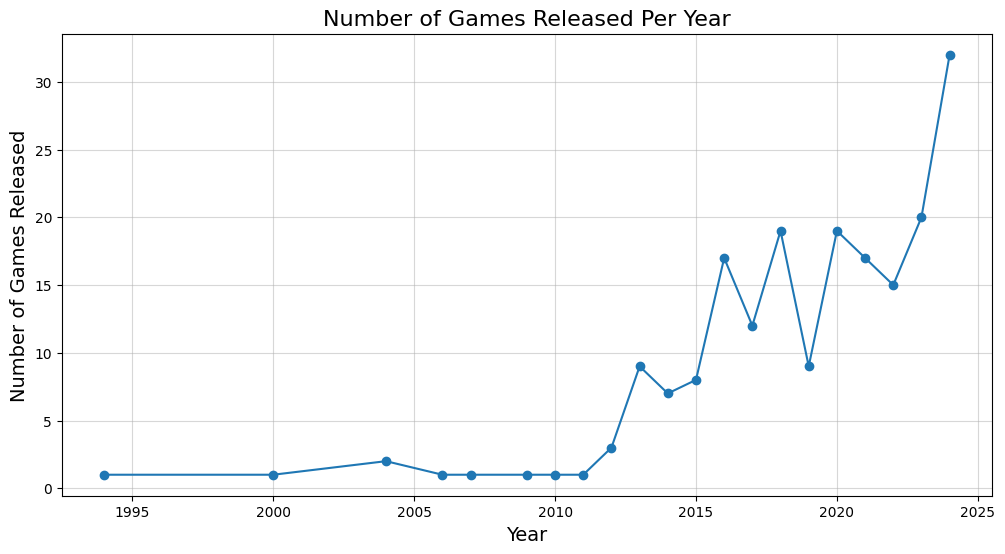

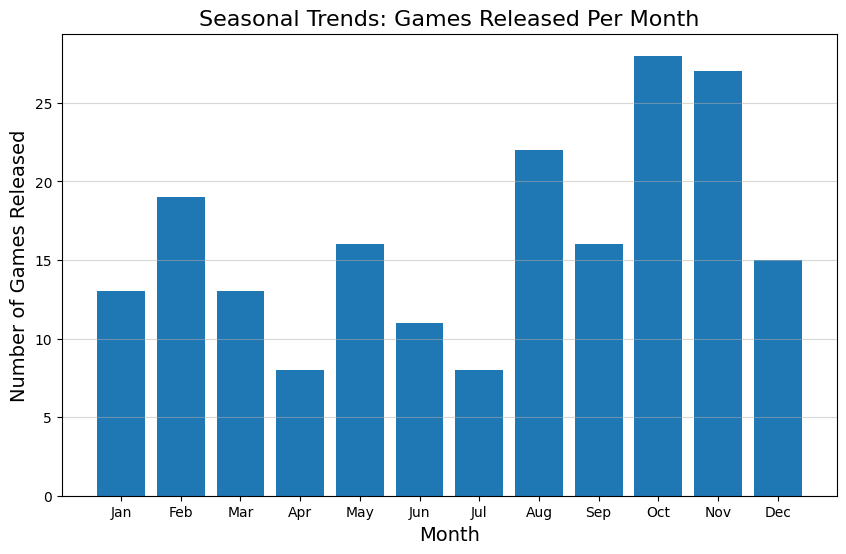

<Figure size 1400x800 with 0 Axes>

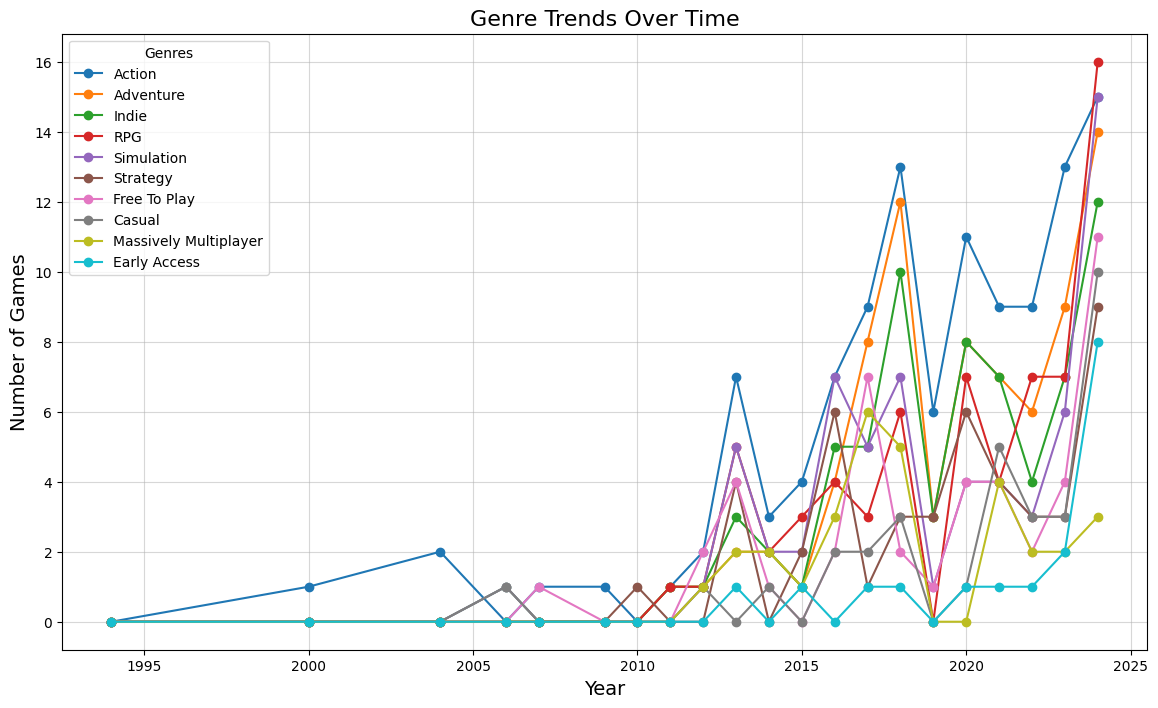

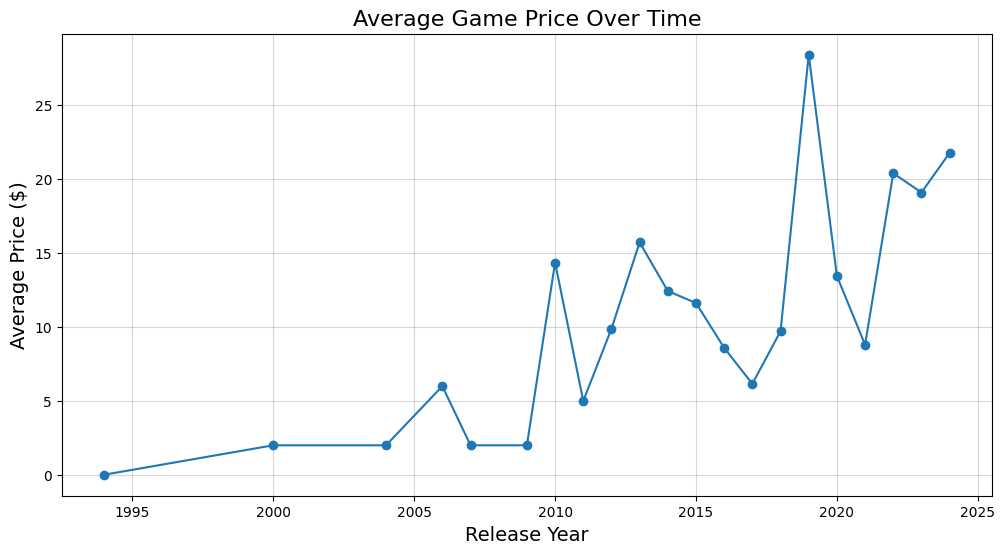

In [11]:
# 6. 시간적 추세

# 데이터세트 로드
file_path = 'clean_total_steam_data.csv'
data = pd.read_csv(file_path)

# "출시 날짜" 열을 날짜/시간 형식으로 변환
data['Release Date'] = pd.to_datetime(data['Release Date'], errors='coerce')

# 날짜가 잘못되었거나 누락된 행 삭제
data = data.dropna(subset=['Release Date'])

# 출시일로부터 연도를 추출
data['Release Year'] = data['Release Date'].dt.year

# 연도별로 그룹화하여 매년 출시되는 게임 수를 계산합니다.
games_per_year = data['Release Year'].value_counts().sort_index()

# 연간 출시되는 게임 수를 도표화하세요.
plt.figure(figsize=(12, 6))
plt.plot(games_per_year.index, games_per_year.values, marker='o')
plt.title('Number of Games Released Per Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Games Released', fontsize=14)
plt.grid(alpha=0.5)
plt.show()

# "출시 월" 열 다시 만들기
data['Release Month'] = data['Release Date'].dt.month

# 계절적 추세를 다시 계산해 보세요.
games_per_month = data['Release Month'].value_counts().sort_index()

# 계절적 추세(매월 출시되는 게임)를 플롯합니다.
plt.figure(figsize=(10, 6))
plt.bar(
    games_per_month.index,
    games_per_month.values,
    tick_label=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)
plt.title('Seasonal Trends: Games Released Per Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Games Released', fontsize=14)
plt.grid(axis='y', alpha=0.5)
plt.show()

# 분석을 위해 "장르" 열을 여러 항목으로 분할
data['Genres List'] = data['Genre'].str.split(',')

# 계산을 위해 장르를 단일 목록으로 정리
all_genres = data.explode('Genres List')['Genres List']

# 각 장르의 발생 횟수를 계산합니다.
genre_counts = all_genres.value_counts()

# 추세 분석을 위해 출시 연도별로 장르를 그룹화합니다.
genre_trends = data.explode('Genres List').groupby(['Release Year', 'Genres List']).size().unstack(fill_value=0)

# 가장 일반적인 장르에 초점을 맞춰 필터링하세요.
top_genres = genre_counts.head(10).index
genre_trends_top = genre_trends[top_genres]

# 시간 경과에 따른 상위 장르의 추세를 플롯합니다.
plt.figure(figsize=(14, 8))
genre_trends_top.plot(figsize=(14, 8), marker='o')
plt.title('Genre Trends Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Games', fontsize=14)
plt.legend(title='Genres', fontsize=10)
plt.grid(alpha=0.5)
plt.show()

# 출시 연도별로 데이터를 그룹화하고 각 연도의 평균 가격을 계산합니다.
average_price_per_year = data.groupby('Release Year')['Price'].mean()

# 시간 경과에 따른 게임의 평균 가격 도표화
plt.figure(figsize=(12, 6))
plt.plot(average_price_per_year.index, average_price_per_year.values, marker='o', linestyle='-')
plt.title('Average Game Price Over Time', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Average Price ($)', fontsize=14)
plt.grid(alpha=0.5)
plt.show()

<ipython-input-85-974940218c8a>:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


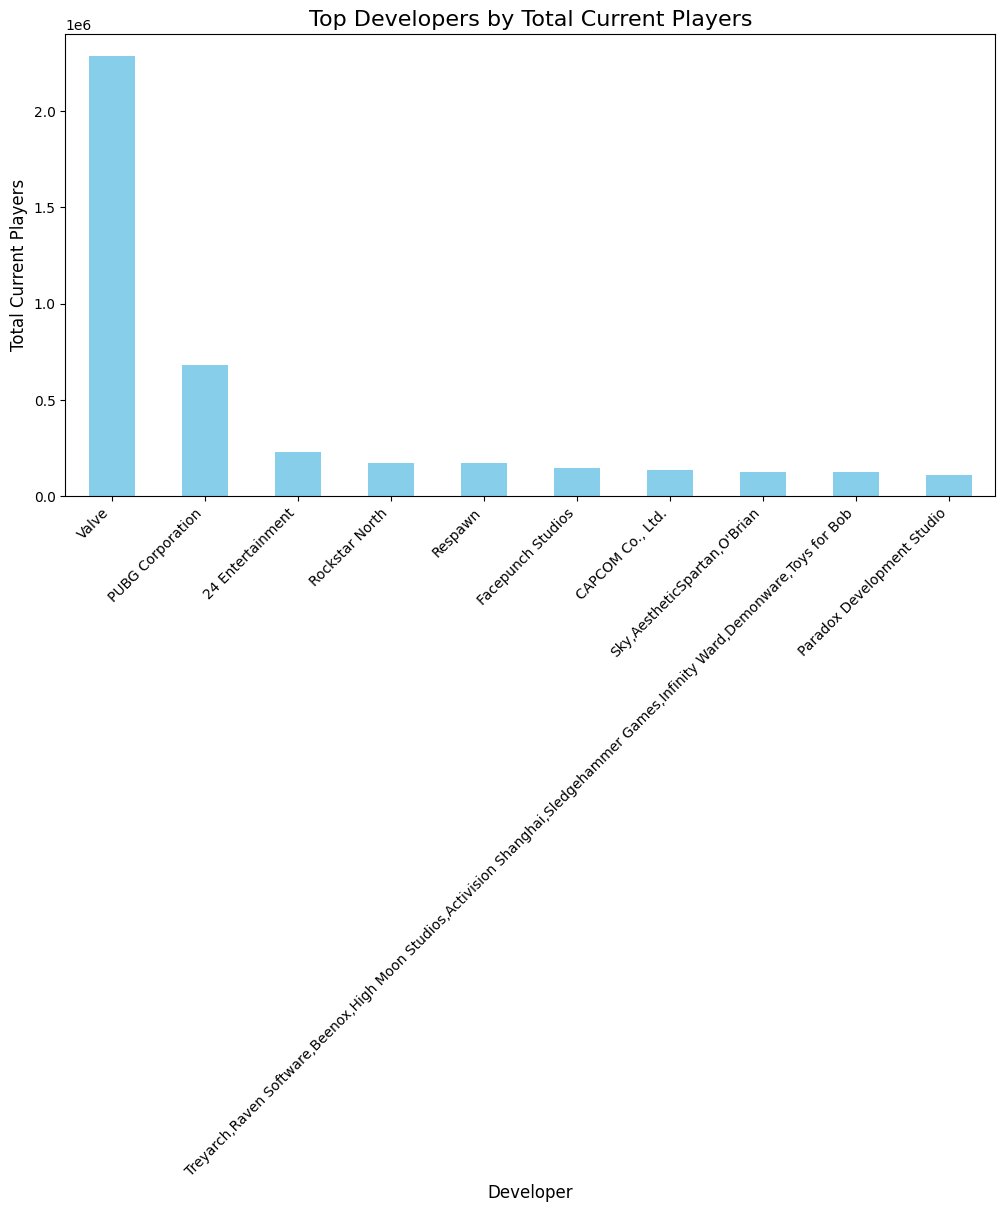

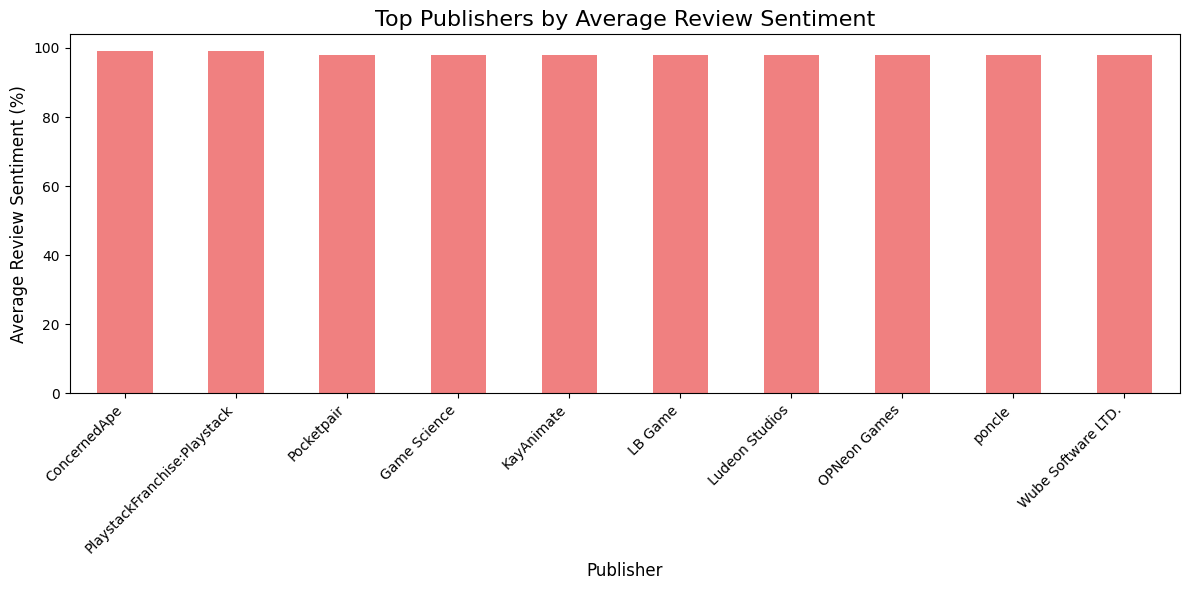

In [85]:
#7. 개발자 및 게시자

# 데이터세트 로드
file_path = 'clean_total_steam_data.csv'
data = pd.read_csv(file_path)

#플레이어 참여도 기준 상위 개발자
# Group by Developer and calculate total player engagement
developer_stats = data.groupby('Developer')[['Current Players', 'Peak Players']].sum()

# Sort by Current Players and get the top 10 developers
top_developers = developer_stats.sort_values(by='Current Players', ascending=False).head(10)

# Bar chart for top developers by total current players
plt.figure(figsize=(12, 6))
top_developers['Current Players'].plot(kind='bar', color='skyblue')
plt.title('Top Developers by Total Current Players', fontsize=16)
plt.xlabel('Developer', fontsize=12)
plt.ylabel('Total Current Players', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

#현재 플레이어별 상위 개발자:
#차트는 게임 전체에서 가장 큰 총 플레이어 기반을 보유한 개발자를 강조합니다.
#Valve 및 PUBG Corporation과 같은 유명 개발업체가 인기 타이틀로 인해 시장을 장악하고 있습니다.

#다양한 기여:
#최고의 개발자들 사이의 다양성은 오랫동안 지속된 거대 기업과 새로운 기업 모두 상당한 플레이어 참여를 달성할 수 있음을 나타냅니다.


#리뷰 감정 기준 상위 게시자
# Group by Publisher and calculate average review sentiment
publisher_stats = data.groupby('Publisher')['Review Sentiment (%)'].mean()

# Sort by review sentiment and get the top 10 publishers
top_publishers = publisher_stats.sort_values(ascending=False).head(10)

# Bar chart for top publishers by average review sentiment
plt.figure(figsize=(12, 6))
top_publishers.plot(kind='bar', color='lightcoral')
plt.title('Top Publishers by Average Review Sentiment', fontsize=16)
plt.xlabel('Publisher', fontsize=12)
plt.ylabel('Average Review Sentiment (%)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

#리뷰 감정 기준 상위 게시자:
#규모는 작지만 열성적인 플레이어 기반을 보유한 게시자는 평균 리뷰 감정이 더 높은 경우가 많습니다.
#이는 틈새시장이나 고품질 게임이 더 호평을 받을 수 있음을 의미합니다.

#광범위한 호소와 표적화된 호소:
#일부 유명 퍼블리셔는 플레이어 참여 측면에서 압도적인 반면, 다른 퍼블리셔는 양보다 질을 강조하며 높은 평가를 받는 경험을 제공하는 데 탁월합니다.

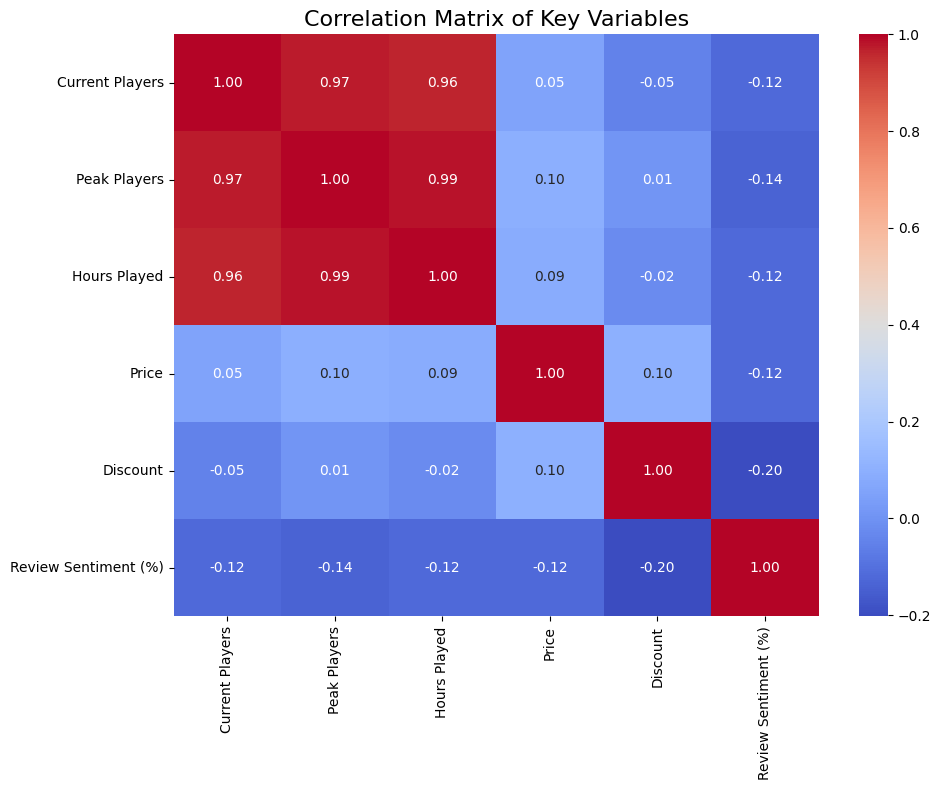

In [12]:
#8. 상관관계 분석
import seaborn as sns

# 데이터세트 로드
file_path = 'clean_total_steam_data.csv'
data = pd.read_csv(file_path)

# Select numerical columns for correlation analysis
numerical_columns = ['Current Players', 'Peak Players', 'Hours Played', 'Price', 'Discount', 'Review Sentiment (%)']
correlation_matrix = data[numerical_columns].corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Key Variables', fontsize=16)
plt.tight_layout()
plt.show()

# 리뷰 음의 상관관계
#예: 인기가 높은 게임에는 기술적인 문제나 밸런스 문제가 있어 높은 참여도에도 불구하고 플레이어 사이에 약간의 불만이 생길 수 있습니다.
#플레이어 기대치: 값비싼 게임에는 더 높은 기준이 적용되며, 기대치가 충족되지 않으면 리뷰가 낮아질 수 있습니다.
#오래된 게임이나 인기가 적은 타이틀은 플레이어의 관심을 끌기 위해 대폭 할인되며, 이는 혼합되거나 부정적인 정서가 있는 게임에 해당할 수 있습니다.

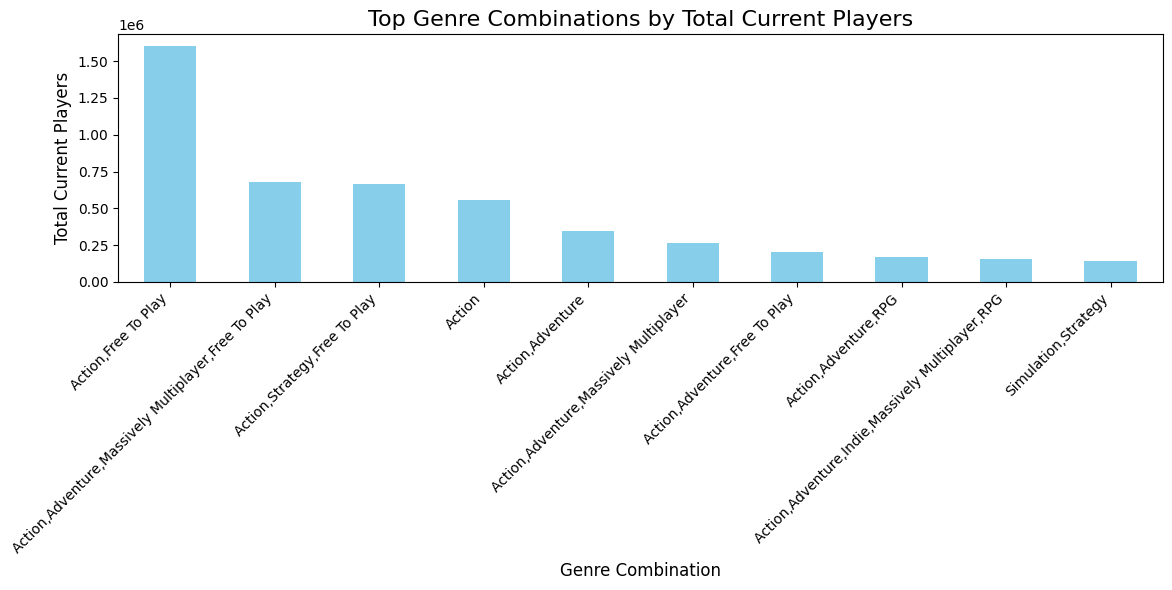

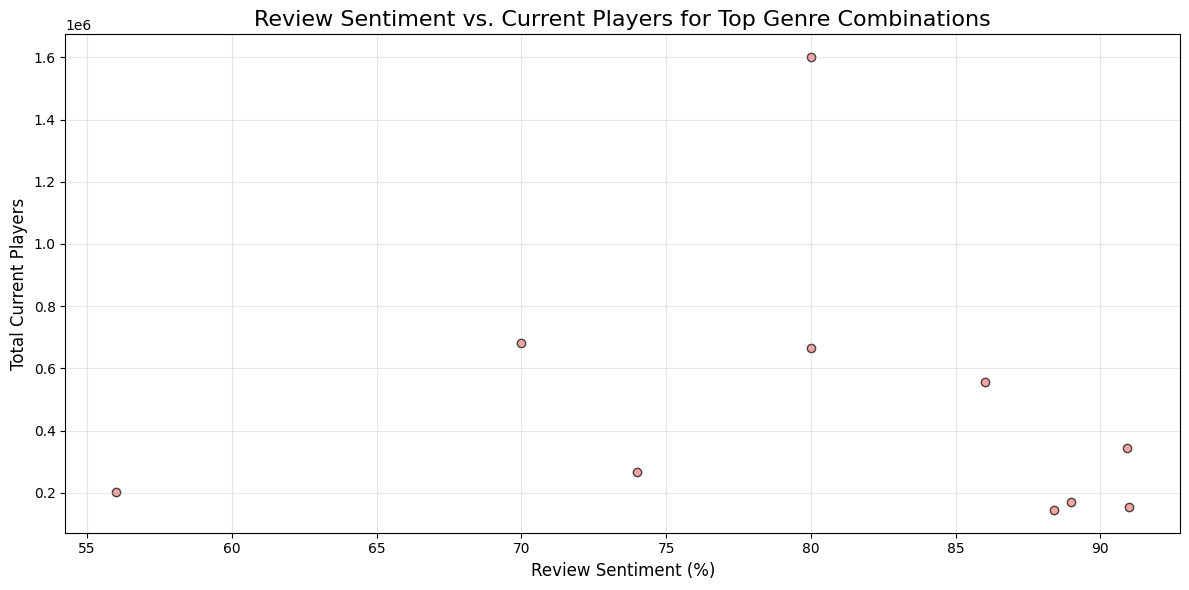

In [91]:
#9. 최고 성과 장르 조합

# 데이터세트 로드
file_path = 'clean_total_steam_data.csv'
data = pd.read_csv(file_path)

#가장 인기 있는 장르 조합:
# Aggregate metrics by unique genre combinations
genre_combinations_analysis = data.groupby('Genre')[['Current Players', 'Hours Played', 'Review Sentiment (%)']].agg({
    'Current Players': 'sum',
    'Hours Played': 'sum',
    'Review Sentiment (%)': 'mean'
})

# Sort by total current players
top_genre_combinations = genre_combinations_analysis.sort_values(by='Current Players', ascending=False).head(10)

# Bar chart for top genre combinations by total current players
plt.figure(figsize=(12, 6))
top_genre_combinations['Current Players'].plot(kind='bar', color='skyblue')
plt.title('Top Genre Combinations by Total Current Players', fontsize=16)
plt.xlabel('Genre Combination', fontsize=12)
plt.ylabel('Total Current Players', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

#액션 + 대규모 멀티플레이어와 같은 장르 조합은 폭넓은 매력과 강력한 참여도를 반영하여 전체 플레이어 수에서 압도적인 비중을 차지합니다.
#모험 + 전략과 같은 다른 조합도 좋은 성과를 거두고 있으며, 이는 틈새 시장 플레이어가 상당한 기여를 하고 있음을 시사합니다.


#감정 및 플레이어 수 검토
# Scatter plot for Review Sentiment vs. Current Players for top combinations
plt.figure(figsize=(12, 6))
plt.scatter(top_genre_combinations['Review Sentiment (%)'], top_genre_combinations['Current Players'], color='lightcoral', edgecolor='black', alpha=0.7)
plt.title('Review Sentiment vs. Current Players for Top Genre Combinations', fontsize=16)
plt.xlabel('Review Sentiment (%)', fontsize=12)
plt.ylabel('Total Current Players', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#리뷰 감정과 플레이어 수 사이에는 엄격한 선형 상관 관계가 없습니다.
#인기가 높은 일부 조합의 리뷰 감정은 중간 정도(~70-80%)로, 이는 플레이어 참여가 감정과 항상 연관되어 있지는 않음을 나타냅니다.
#반대로, 매우 높은 감정(>85%)을 가진 조합에는 플레이어 수가 적은 경우가 많으며, 이는 틈새 잠재고객이 인기보다 품질을 중요시한다는 것을 의미합니다.